## TODO: Insert your surname, name and ID number

Student surname: Festa

Student name: Filippo
    
ID: 2029789

# Characters Classification with Neural Networks

In this notebook we are going to use the Neural Networks for image classification. We are going to use the same dataset of the lab on SVM: Kuzushiji-MNIST or K-MNIST for short (https://github.com/rois-codh/kmnist) a dataset of traditional japanese handwritten kana.

The dataset labels are the following:

| Label | Hiragana Character | Romanji (Pronunciation) |
| :-: | :-: | :-: |
|   0   | お | o |
| 1 | き | ki |
| 2 | す | su |
| 3 | つ | tsu |
| 4 | な | na |
| 5 | は | ha |
| 6 | ま | ma |
| 7 | や | ya |
| 8 | れ | re |
| 9 | を | wo |

In [3]:
#load the required packages and check Scikit-learn version

%matplotlib inline  

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import sklearn
print ('scikit-learn version: ', sklearn.__version__)
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn import metrics
from sklearn.exceptions import ConvergenceWarning
from sklearn.svm import SVC
from sklearn import linear_model

bold = "\033[1m"
end = "\033[0m"

scikit-learn version:  0.23.2


In [4]:
# helper function to load KMNIST dataset from disk
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np
    labels_path = os.path.join(path, 'K%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, 'K%s-images-idx3-ubyte.gz' % kind)
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(labels), 784)
    return images, labels

# TODO 
Set as seed for the random generator your Student ID (you can use your "numero di matricola"). Try to change the seed to see the impact of the randomization.

In [5]:
ID = 2029789
np.random.seed(ID)

In [6]:
#load the MNIST dataset and let's normalize the features so that each value is in [0,1]
X, y = load_mnist("data")
print("Number of samples in the K-MNIST dataset - X.shape[0]:", X.shape[0])


# rescale the data
X = X / 255.0

print("\nX shape:", X.shape)
print("X:\n", X)

print("\ny shape:", y.shape)
print("y:", y)

Number of samples in the K-MNIST dataset - X.shape[0]: 60000

X shape: (60000, 784)
X:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

y shape: (60000,)
y: [8 7 0 ... 0 4 9]


Now split into training and test. We start with a small training set of 600 samples to reduce computation time while 4000 samples will be used for testing. Make sure that each label is present at least 10 times in train and test set frequencies.

In [7]:
# Random permute the data and split into training and test taking the first 600
# data samples as training and 4000 as test set

permutation = np.random.permutation(X.shape[0])

X = X[permutation]
y = y[permutation]

m_training = 600
m_test = 4000

X_train, X_test = X[:m_training], X[m_training:m_training+m_test]
y_train, y_test = y[:m_training], y[m_training:m_training+m_test]

print("\nY_training:\n", y_train)
print("Shape of X_training set: " + str(X_train.shape))
print("Shape of Y_training set: " + str(y_train.shape))

print("\nY_test:\n", y_test)
print("Shape of X_test set: " + str(X_test.shape))
print("Shape of Y_test set: " + str(y_test.shape))


labels, freqs = np.unique(y_train, return_counts=True)
print("\nLabels in training y_train dataset: ", labels)
print("Frequencies in training y_train dataset: ", freqs)

labelsT, freqsT = np.unique(y_test, return_counts=True)
print("\nLabels in test y_test set: ", labels)
print("Frequencies in test y_test set: ", freqs)



Y_training:
 [3 7 7 7 4 2 0 0 4 0 7 8 6 8 4 7 2 5 7 9 5 7 5 7 1 8 1 3 1 6 8 5 3 6 5 8 4
 7 1 5 8 0 0 3 7 6 6 0 3 3 3 4 4 3 1 3 2 9 2 9 9 7 5 2 9 5 7 7 1 4 4 1 9 4
 0 0 2 4 8 7 8 2 0 3 4 5 5 5 7 2 2 1 2 4 7 3 0 0 1 3 5 6 7 2 5 5 8 7 1 5 3
 8 1 7 0 4 2 1 9 0 9 6 9 2 5 1 6 1 5 0 3 5 6 9 4 2 1 7 7 3 2 1 9 5 1 7 5 4
 8 7 2 7 8 9 4 6 3 3 0 7 9 1 0 9 4 9 1 5 2 7 5 5 2 5 9 8 0 2 4 8 2 8 3 3 8
 3 2 1 5 0 8 5 6 4 4 6 0 3 9 6 7 7 4 9 3 6 7 0 5 3 9 9 4 1 7 1 6 0 5 1 4 8
 0 5 7 9 6 4 5 1 9 9 0 4 0 6 3 1 6 2 2 8 5 7 3 6 9 3 5 9 9 4 6 1 7 8 9 1 7
 2 1 2 7 3 7 6 2 7 6 8 1 4 5 8 5 8 8 1 0 0 8 5 3 6 2 4 0 2 6 4 1 5 5 5 2 8
 3 0 1 4 8 1 9 7 3 1 8 8 6 1 4 6 2 1 1 3 7 0 4 4 3 2 0 7 0 2 1 0 1 6 5 6 0
 8 8 4 7 8 8 2 5 2 7 7 9 2 0 8 1 6 1 5 0 4 6 9 5 5 8 9 9 9 9 7 8 4 7 7 9 3
 5 3 0 5 6 9 8 4 0 1 9 4 8 7 2 5 5 3 4 9 1 8 5 4 0 4 2 4 4 8 3 2 7 7 3 0 8
 7 1 8 0 7 9 1 4 2 8 1 6 3 7 6 6 1 4 4 4 5 1 8 9 4 0 1 4 5 3 8 5 0 3 4 9 1
 5 7 0 7 2 3 7 5 0 9 1 4 2 3 8 2 0 5 8 3 0 9 5 7 8 4 4 4 0 7 7 8 0 5 8 3 7
 8 5 3 5 1 

In [8]:
#function for plotting a image and printing the corresponding label
def plot_input(X_matrix, labels, index):
    print("INPUT:")
    
    plt.imshow(
        X_matrix[index].reshape(28,28),
        cmap          = plt.cm.gray_r,
        interpolation = "nearest"
    )
    plt.show()
    
    print("LABEL: %i"%labels[index])
    return

INPUT:


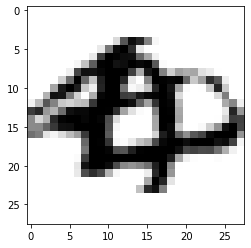

LABEL: 7



INPUT:


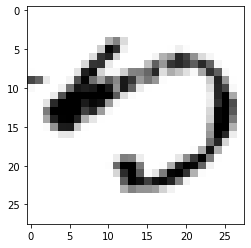

LABEL: 3



INPUT:


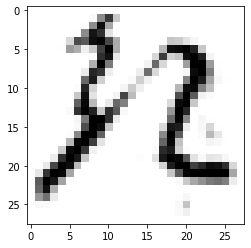

LABEL: 1


In [9]:
#let's try the plotting function

plot_input(X_train,y_train,10)
print("\n\n")

plot_input(X_test,y_test,100)
print("\n\n")

plot_input(X_test,y_test,1000)

### TO DO 1

Now use a feed-forward Neural Network for prediction. Use the multi-layer perceptron classifier, with the following parameters: max_iter=100, alpha=1e-4, solver='sgd', tol=1e-4, learning_rate_init=.1, random_state=ID (this last parameter ensures the run is the same even if you run it more than once). The alpha parameter is the regularization term.

Then, using the default activation function, pick four or five architectures to consider, with different numbers of hidden layers and different sizes. It is not necessary to create huge neural networks, you can limit to 3 layers and, for each layer, its maximum size can be of 50. Evaluate the architectures you chose using GridSearchCV with cv=5.

You can reduce the number of iterations if the running time is too long on your computer.


In [10]:
# these are sample values but feel free to change them as you like, try to experiment with different sizes!!
parameters = {'hidden_layer_sizes': [(10,), (20,), (40,), (20,20,), (40,20,10) ]}

mlp = MLPClassifier(max_iter = 100, alpha = 1e-4, solver = 'sgd', tol = 1e-4, random_state = ID, learning_rate_init = .1)

gdsea = GridSearchCV(mlp, parameters, cv = 5, refit = True, verbose = 3, n_jobs = -1) 
gdsea.fit(X_train, y_train) 


print (bold + '\nRESULTS FOR FEED-FORWARD NEURAL NETWORK\n' + end)

best_architecture = [*gdsea.best_params_.values()][0]
print(bold + "\n- Best parameters set found:" + end, gdsea.best_params_)

results_df = pd.DataFrame(gdsea.cv_results_)
print(bold + "\n- Score with best parameters:" + end, gdsea.best_score_, "+- %.5f" %results_df.std_test_score.loc[gdsea.best_index_])

print(bold + "\n\n- All scores on the grid:\n" + end)
results_df

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   11.4s finished



RESULTS FOR FEED-FORWARD NEURAL NETWORK


- Best parameters set found: {'hidden_layer_sizes': (40,)}

- Score with best parameters: 0.7316666666666667 +- 0.02261


- All scores on the grid:



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_hidden_layer_sizes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.111406,0.045849,0.003125,0.006251,"(10,)","{'hidden_layer_sizes': (10,)}",0.675000,0.716667,0.641667,0.641667,0.675000,0.670000,0.027689,5
1,1.113165,0.092107,0.000000,0.000000,"(20,)","{'hidden_layer_sizes': (20,)}",0.658333,0.758333,0.725000,0.733333,0.775000,0.730000,0.040000,2
2,1.373516,0.095062,0.000000,0.000000,"(40,)","{'hidden_layer_sizes': (40,)}",0.716667,0.741667,0.700000,0.766667,0.733333,0.731667,0.022608,1
3,1.088247,0.231895,0.003204,0.003924,"(20, 20)","{'hidden_layer_sizes': (20, 20)}",0.691667,0.725000,0.716667,0.808333,0.700000,0.728333,0.041700,3
4,1.185061,0.155849,0.003125,0.006250,"(40, 20, 10)","{'hidden_layer_sizes': (40, 20, 10)}",0.700000,0.708333,0.675000,0.741667,0.708333,0.706667,0.021344,4


### TO DO 2

Now try also different batch sizes, while keeping the best NN architecture you have found above. Remember that the batch size was previously set to the default value, i.e., min(200, n_samples). 
Recall that a batch size of 1 corresponds to baseline SGD, while using all the 480 training samples (there are 600 samples but in cross validation with 5 folders we use 1/5 of them for validation at each round) corresponds to standard GD and using a different mini-batch size lies in the middle between the two extreme cases.

In [15]:
# these are sample values corresponding to baseline SGD, a reasonable mini-batch size and standard GD
# again feel free to change them as you like, try to experiment with different batch sizes!!
parameters = {'batch_size': [1, 32, 480]}

# need to specify that you would like to use the standard k-fold split otherwise sklearn create splits of different sizes
kf = sklearn.model_selection.KFold(n_splits = 5)


# recall to use cv=kf to use the k-fold subdivision seen in the lectures

mlp = MLPClassifier(max_iter = 100, hidden_layer_sizes = best_architecture, alpha = 1e-4, solver = 'sgd', tol = 1e-4,
                    random_state = ID, learning_rate_init = .1)

gdsea = GridSearchCV(mlp, parameters, cv = kf, refit = True, verbose = 3, n_jobs = -1) 
gdsea.fit(X_train, y_train) 


print (bold + '\nRESULTS FOR FEED-FORWARD NEURAL NETWORK\n' + end)

best_batchsize = [*gdsea.best_params_.values()][0]
print(bold + "\n- Best parameters set found:" + end, gdsea.best_params_)

results_df = pd.DataFrame(gdsea.cv_results_)
print(bold + "\n- Score with best parameters:" + end, gdsea.best_score_, "+- %.5f" %results_df.std_test_score.loc[gdsea.best_index_])

print(bold + "\n\n- All scores on the grid:\n" + end)
results_df


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.0min finished



RESULTS FOR FEED-FORWARD NEURAL NETWORK


- Best parameters set found: {'batch_size': 32}

- Score with best parameters: 0.7283333333333333 +- 0.03894


- All scores on the grid:



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,74.890923,12.916640,0.003200,0.006400,1,{'batch_size': 1},0.058333,0.100000,0.100000,0.108333,0.058333,0.085000,0.021985,3
1,1.609273,0.055708,0.001601,0.003201,32,{'batch_size': 32},0.733333,0.775000,0.725000,0.658333,0.750000,0.728333,0.038944,1
2,1.610197,0.105099,0.000000,0.000000,480,{'batch_size': 480},0.716667,0.758333,0.708333,0.650000,0.783333,0.723333,0.045765,2


### QUESTION 1

What do you observe for different architectures and batch sizes? How do the number of layers and their sizes affect the performances? What do you observe for different batch sizes, in particular what happens to the training convergence for different batch sizes (notice that the algorithm could not converge for some batch sizes)?



I observe that:
- The best architecture is the one with only one hidden layer made of 40 nodes
- The best batch size is 32 $\newline$

Moreover for different number of layers and sizes I get the mean score:
- Hidden layer sizes $(10,) \Rightarrow 0.67$
- Hidden layer sizes $(20,) \Rightarrow 0.73$
- Hidden layer sizes $(40,) \Rightarrow 0.731667$	
- Hidden layer sizes $(20, 20) \Rightarrow 0.728333$	
- Hidden layer sizes $(40, 20, 10) \Rightarrow 0.706667$	
$\newline$Notice that the two architectures $(10,)$ and $(20,)$ I got two very similar scores, this is likely due to the fact they share the same number of hidden layers (that is one: in particular a one hidden layer neural network can approximate any function that contains a continuous mapping from one finite space to another) and a similar hidden layer's sizes.  $\newline$

For different batch sizes I get the mean score:
- Batch size $1 \Rightarrow 0.085$ 
- Batch size $32 \Rightarrow 0.7283$
- Batch size $480 \Rightarrow 0.7233$
$\newline$Notice that the standard Gradient Descent(Batch Gradient Descent) and the Mini-Batch Gradient Descent got very similar scores, moreover the algorithm converges in all cases.

### TODO 3:

Plot the train and test accuracies as a function of the number of learnable parameters in your neural network. Print also the computation time for the various configurations you try (the code for getting the computation time is already provided). You can use 100 iterations (if you get a warning on convergence not reached it is not an issue for this lab)

					CASE ZERO - Default Batch Size

Training MLP of size (10,) ...
  => Number of learnable parameters: 7960
  => Done, training time: 0.92 sec

Training MLP of size (20,) ...
  => Number of learnable parameters: 15910
  => Done, training time: 1.01 sec

Training MLP of size (40,) ...
  => Number of learnable parameters: 31810
  => Done, training time: 1.02 sec

Training MLP of size (20, 20) ...
  => Number of learnable parameters: 16330
  => Done, training time: 0.67 sec

Training MLP of size (40, 20, 10) ...
  => Number of learnable parameters: 32540
  => Done, training time: 0.83 sec



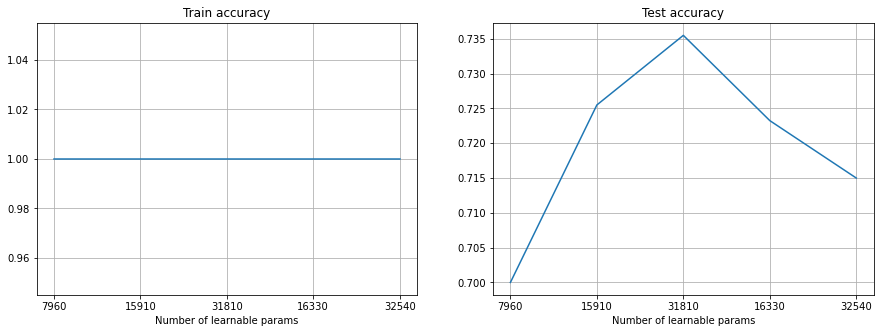

In [16]:
import time
from functools import reduce

# Function to compute the number of learnable parameters of a mlp given the size of its hidden layers
def param_count(hl_size):
    
    tot = 0
    input_size, output_size = X_train.shape[1], len(labels)
    tot += (input_size+1)*hl_size[0]
    
    for i in range(1,len(hl_size)):
        tot += (hl_size[i-1]+1)*hl_size[i]
        
    tot += (hl_size[-1]+1)*output_size
    return tot


hl_sizes = [(10,), (20,), (40,), (20,20,), (40,20,10)]
hl_labels = [param_count(t) for t in hl_sizes]

ti = time.time()
train_acc_list, test_acc_list = [], []


print(bold + "\t\t\t\t\tCASE ZERO - Default Batch Size\n" + end)
for hl_size, hl_label in zip(hl_sizes, hl_labels):
    
    print('Training MLP of size {} ...'.format(hl_size))
    print("  => Number of learnable parameters:", hl_label)
    
    mlp = MLPClassifier(max_iter = 100, hidden_layer_sizes = hl_size, alpha = 1e-4, solver = 'sgd', tol = 1e-4, 
                        random_state = ID, learning_rate_init = .1)  
    mlp.fit(X_train, y_train)
    
    train_acc_list.append(mlp.score(X_train, y_train))
    test_acc_list.append(mlp.score(X_test, y_test))
    print('  => Done, training time: {:.2f} sec\n'.format(time.time()-ti))
    ti = time.time()

    
    
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(train_acc_list)
ax[0].set_xlabel('Number of learnable params')
ax[0].set_title('Train accuracy')
ax[0].set_xticks(np.arange(0,len(hl_labels)))
ax[0].set_xticklabels(hl_labels)
ax[0].grid(True)

ax[1].plot(test_acc_list)
ax[1].set_xlabel('Number of learnable params')
ax[1].set_title('Test accuracy')
ax[1].set_xticks(np.arange(0,len(hl_labels)))
ax[1].set_xticklabels(hl_labels)
ax[1].grid(True)


					CASE ONE - Batch Size = 32 

Training MLP of size (10,) ...
  => Number of learnable parameters: 7960
  => Done, training time: 2.38 sec

Training MLP of size (20,) ...
  => Number of learnable parameters: 15910
  => Done, training time: 1.02 sec

Training MLP of size (40,) ...
  => Number of learnable parameters: 31810
  => Done, training time: 1.19 sec

Training MLP of size (20, 20) ...
  => Number of learnable parameters: 16330
  => Done, training time: 1.15 sec

Training MLP of size (40, 20, 10) ...
  => Number of learnable parameters: 32540
  => Done, training time: 1.33 sec



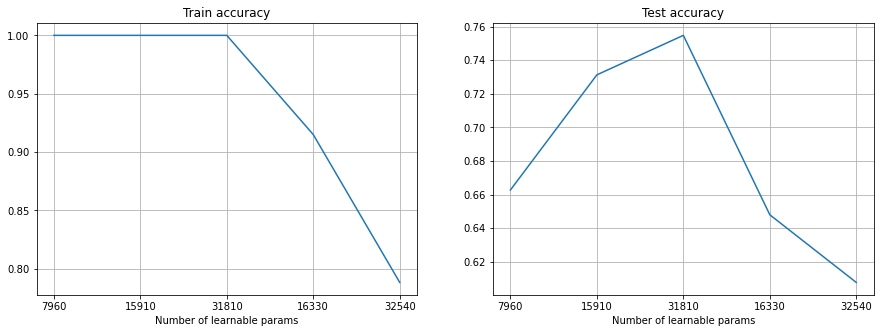

In [17]:
train_acc_list, test_acc_list = [], []

print(bold + "\t\t\t\t\tCASE ONE - Batch Size = " + str(best_batchsize) + end, "\n")
for hl_size, hl_label in zip(hl_sizes, hl_labels):
    
    print('Training MLP of size {} ...'.format(hl_size))
    print("  => Number of learnable parameters:", hl_label)
    
    mlp = MLPClassifier(max_iter = 100, hidden_layer_sizes = hl_size, alpha = 1e-4, solver = 'sgd', tol = 1e-4, batch_size = best_batchsize,
                        random_state = ID, learning_rate_init = .1)  
    mlp.fit(X_train, y_train)
    
    train_acc_list.append(mlp.score(X_train, y_train))
    test_acc_list.append(mlp.score(X_test, y_test))
    print('  => Done, training time: {:.2f} sec\n'.format(time.time()-ti))
    ti = time.time()

    
    
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(train_acc_list)
ax[0].set_xlabel('Number of learnable params')
ax[0].set_title('Train accuracy')
ax[0].set_xticks(np.arange(0,len(hl_labels)))
ax[0].set_xticklabels(hl_labels)
ax[0].grid(True)

ax[1].plot(test_acc_list)
ax[1].set_xlabel('Number of learnable params')
ax[1].set_title('Test accuracy')
ax[1].set_xticks(np.arange(0,len(hl_labels)))
ax[1].set_xticklabels(hl_labels)
ax[1].grid(True)


## Question 2:

Comment about the training and test accuracies referring to the discussion on underfitting and overfitting we did in the course

I tested two different cases:
- **Default Batch Size**
$\newline$I can observe that the training accuracy is always one over the whole range of the number of learnable parameters. Instead for what concerns the test accuracy we get a sort of broken peaked trend with the maximum at 31810, that is number of learnable parameters. The result it's the overfitting and the extreme specialization of the classifier on the training data.$\newline$

- **Best Batch Size = 32**
$\newline$The training accuracy is always one until it reaches the value 31810, when it start to decreases. Instead for what concerns the test accuracy we get a sort of broken peaked trend with the maximum at 31810 that is very similar to what we've obtained before. The model seems to be too simple and not able to generalize we on the training samples, the result is the underfitting.

### TO DO 4

Now try also to use different learning rates, while keeping the best NN architecture and batch size you have found above. Plot the learning curves (i.e., the variation of the loss over the steps, you can get it from the loss_curve_ object of sklearn) for the different values of the learning rate. Try to run each training for 100 iterations. 




Scores: {'0.0002': 0.7783333333333333, '0.002': 1.0, '0.02': 1.0, '0.2': 0.93}



RESULTS FOR FEED-FORWARD NEURAL NETWORK

Best parameters set found: {'learning_rate': 0.002 }
Score with best parameters: 1.0





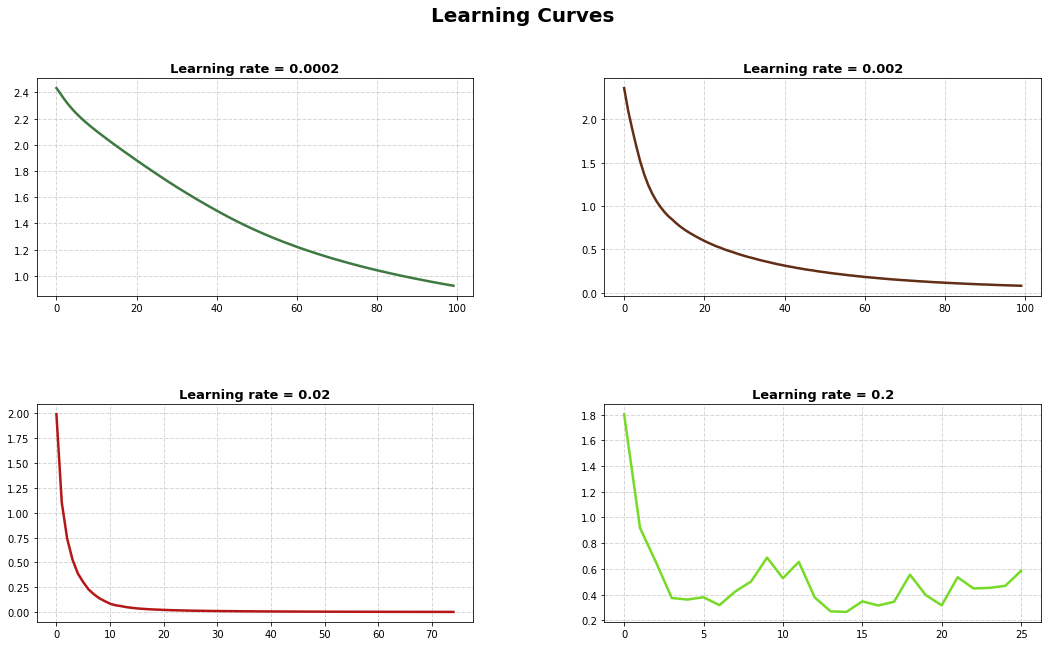

In [23]:
import matplotlib.pyplot as plt
import operator

lr_list = [0.0002, 0.002, 0.02, 0.2]
scores = {}

fig, ax = plt.subplots(2, 2, figsize = (18, 10))
fig.subplots_adjust(hspace = 0.5, wspace = 0.3)
fig.suptitle("Learning Curves", fontsize = 20, fontweight = 'bold')
for i in range(4):
    
    mlp = MLPClassifier(max_iter = 100, hidden_layer_sizes = best_architecture, alpha = 1e-4, solver = 'sgd', tol = 1e-4,
                    batch_size = best_batchsize, random_state = ID, learning_rate_init = lr_list[i]) 
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category = ConvergenceWarning, module = "sklearn")
        mlp.fit(X_train, y_train)
    
   
    scores.update({str(lr_list[i]): mlp.score(X_train, y_train)})
    
    if i < 2:
        ax[0, i].plot(mlp.loss_curve_, label = str(lr_list[i]), linewidth = 2.5, c = "#%06X"%np.random.randint(0, 0xFFFFFF))
        ax[0, i].set_title("Learning rate = " + str(lr_list[i]), fontsize = 13, fontweight = 'bold')
        ax[0, i].grid(linestyle = '--', linewidth = 1, alpha = 0.5)
    else:
        ax[1, i-2].plot(mlp.loss_curve_, label = str(lr_list[i]), linewidth = 2.5, c = "#%06X"%np.random.randint(0, 0xFFFFFF))
        ax[1, i-2].set_title("Learning rate = " + str(lr_list[i]), fontsize = 13, fontweight = 'bold')
        ax[1, i-2].grid(linestyle = '--', linewidth = 1, alpha = 0.5)
        
    
   

print("\n\n\nScores:", scores)
print("\n")


best_learning_rate = max(scores, key = scores.get)
print(bold + '\nRESULTS FOR FEED-FORWARD NEURAL NETWORK\n' + end)
print(bold + "Best parameters set found:" + end, "{'learning_rate':", best_learning_rate, "}" )
print(bold + "Score with best parameters:" + end, scores[best_learning_rate])  
print("\n\n")

In [24]:
parameters = {'learning_rate_init': [0.0002, 0.002, 0.02, 0.2]}

kf = sklearn.model_selection.KFold(n_splits = 5)

mlp = MLPClassifier(max_iter = 100, hidden_layer_sizes = best_architecture, alpha = 1e-4, solver = 'sgd', tol = 1e-4,
                    batch_size = best_batchsize, random_state = ID)

gdsea = GridSearchCV(mlp, parameters, cv = kf, refit = True, verbose = 3, n_jobs = -1) 
gdsea.fit(X_train, y_train) 


print (bold + '\nRESULTS FOR FEED-FORWARD NEURAL NETWORK\n' + end)

best_learning_rate = [*gdsea.best_params_.values()][0]
print(bold + "\n- Best parameters set found:" + end, gdsea.best_params_)

results_df = pd.DataFrame(gdsea.cv_results_)
print(bold + "\n- Score with best parameters:" + end, gdsea.best_score_, "+- %.5f" %results_df.std_test_score.loc[gdsea.best_index_])

print(bold + "\n\n- All scores on the grid:\n" + end)
results_df


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   24.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   24.5s finished



RESULTS FOR FEED-FORWARD NEURAL NETWORK


- Best parameters set found: {'learning_rate_init': 0.002}

- Score with best parameters: 0.715 +- 0.04327


- All scores on the grid:



C:\ProgramData\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.078364,0.107201,0.003124,0.006248,0.0002,{'learning_rate_init': 0.0002},0.625000,0.633333,0.616667,0.708333,0.650000,0.646667,0.032745,4
1,5.155831,0.093785,0.000000,0.000000,0.002,{'learning_rate_init': 0.002},0.708333,0.733333,0.716667,0.641667,0.775000,0.715000,0.043269,1
2,4.183307,0.148020,0.001601,0.003203,0.02,{'learning_rate_init': 0.02},0.708333,0.750000,0.708333,0.641667,0.733333,0.708333,0.036893,2
3,1.504557,0.402147,0.003126,0.006252,0.2,{'learning_rate_init': 0.2},0.666667,0.691667,0.650000,0.716667,0.700000,0.685000,0.023805,3


### QUESTION 3

Comment about the learning curves (i.e. the variation of the loss over the steps). How does the curve changes for different learning rates in terms of stability and speed of convergence ?

We can observe that the smooth and stable learning curves are the first three, of which the ones associated to 0.02 and 0.002 quickly converge toward zero also before the maximum number of iterarions. The last learning curve is not very stable that may be a sign of overfitting.

### TO DO 5

Now get training and test error for a NN with best parameters (architecture, batch size and learning rate) from above. Plot the learning curve also for this case (you can run the training for 500 iterations).


RESULTS FOR BEST FEED-FORWARD NEURAL NETWORK
  => Best NN training error: 0.000000
  => Best NN test error: 0.260750 




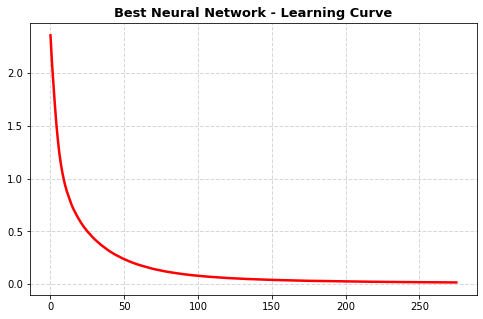

In [25]:
# get training and test error for the best NN model from CV

mlp = MLPClassifier(max_iter = 500, hidden_layer_sizes = best_architecture, alpha = 1e-4, solver = 'sgd', tol = 1e-4,
                    batch_size = best_batchsize, random_state = ID, learning_rate_init = best_learning_rate) 
mlp.fit(X_train, y_train)


print (bold + '\nRESULTS FOR BEST FEED-FORWARD NEURAL NETWORK' + end)

training_error = 1 - mlp.score(X_train, y_train) 
test_error = 1 - mlp.score(X_test, y_test)

print("  => Best NN training error: %f" % training_error)
print("  => Best NN test error: %f" % test_error, "\n\n")


#ADD YOUR CODE FOR PLOTTING
fig, ax = plt.subplots(1, 1, figsize = (8, 5))
ax.plot(mlp.loss_curve_, linewidth = 2.5, c = "r")
ax.set_title("Best Neural Network - Learning Curve", fontsize = 13, fontweight = 'bold')
ax.grid(linestyle = '--', linewidth = 1, alpha = 0.5)

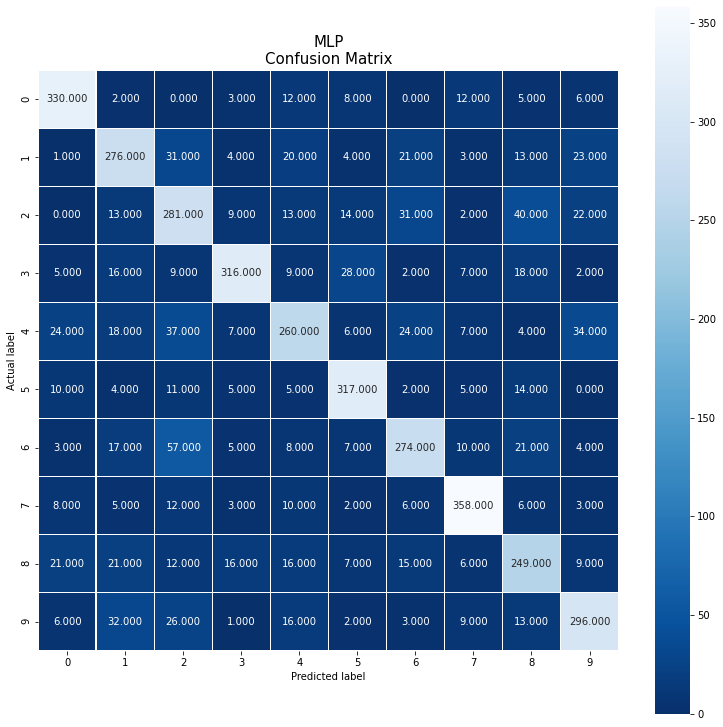

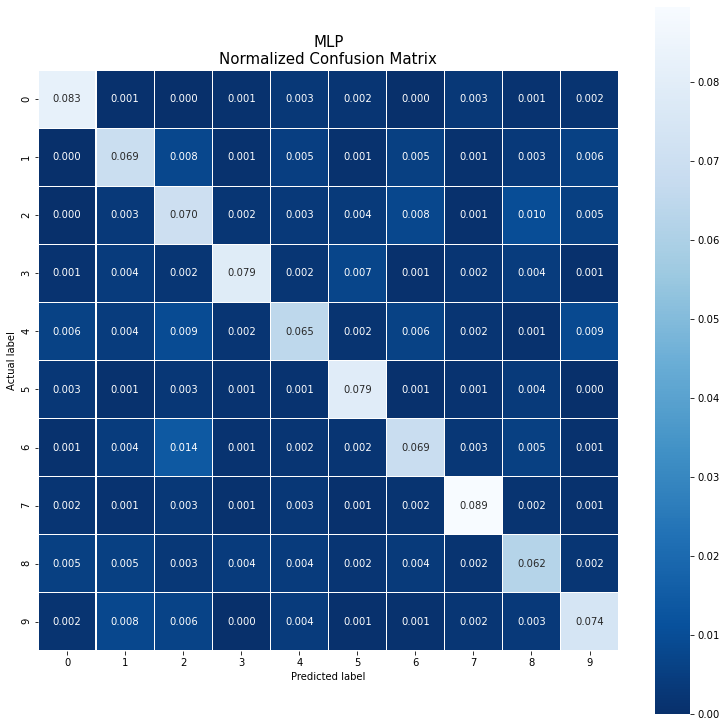

In [27]:
NN_prediction = mlp.predict(X_test)
cm = metrics.confusion_matrix(y_test, NN_prediction)

plt.figure(figsize = (13,13))
sns.heatmap(cm, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('MLP\nConfusion Matrix', size = 15);
plt.show()


cmn = metrics.confusion_matrix(y_test, NN_prediction, normalize='all')
plt.figure(figsize = (13,13))
sns.heatmap(cmn, annot = True, fmt='.3f', linewidths = .5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('MLP\nNormalized Confusion Matrix', size = 15);
plt.show()

## More data 
Now let's do the same but using 4000 (or less if it takes too long on your machine) data points for training. Use the same NN architecture as before, but you can try more if you like and have a powerful computer!!

In [36]:
X = X[permutation]
y = y[permutation]

m_training = 4000

X_train, X_test = X[:m_training], X[m_training:]
y_train, y_test = y[:m_training], y[m_training:]

print("\nY_training:\n", y_train)
print("Shape of X_training set: " + str(X_train.shape))
print("Shape of Y_training set: " + str(y_train.shape))

print("\nY_test:\n", y_test)
print("Shape of X_test set: " + str(X_test.shape))
print("Shape of Y_test set: " + str(y_test.shape))



labels, freqs = np.unique(y_train, return_counts = True)
print("\nLabels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

labelsT, freqsT = np.unique(y_test, return_counts=True)
print("\nLabels in test y_test set: ", labelsT)
print("Frequencies in test y_test set: ", freqsT)



Y_training:
 [3 3 3 ... 6 8 2]
Shape of X_training set: (4000, 784)
Shape of Y_training set: (4000,)

Y_test:
 [2 4 4 ... 0 0 9]
Shape of X_test set: (56000, 784)
Shape of Y_test set: (56000,)

Labels in training dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in training dataset:  [406 366 409 409 392 408 407 401 427 375]

Labels in test y_test set:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in test y_test set:  [5594 5634 5591 5591 5608 5592 5593 5599 5573 5625]


### TO DO 6

Now train the NNs with the added data points using the optimum parameters found above. Eventually, feel free to try different architectures if you like. We suggest that you use 'verbose=True' so have an idea of how long it takes to run 1 iteration (eventually reduce also the number of iterations to 50).

In [37]:
# Use best architecture and params from before

mlp_large = MLPClassifier(max_iter = 500, hidden_layer_sizes = best_architecture, alpha = 1e-4, solver = 'sgd', tol = 1e-4,
                    verbose = True, batch_size = best_batchsize, random_state = ID, learning_rate_init = best_learning_rate) 
mlp_large.fit(X_train, y_train)



print (bold + '\nRESULTS FOR BEST FEED-FORWARD NEURAL NETWORK' + end)

# Get training and test error for the NN

training_error = 1 - mlp_large.score(X_train, y_train) 
test_error = 1 - mlp_large.score(X_test, y_test)

print("  => NN training error: %f" % training_error)
print("  => NN test error: %f" % test_error)


Iteration 1, loss = 1.84817318
Iteration 2, loss = 1.15682412
Iteration 3, loss = 0.92108420
Iteration 4, loss = 0.79738273
Iteration 5, loss = 0.72247709
Iteration 6, loss = 0.66615844
Iteration 7, loss = 0.62538505
Iteration 8, loss = 0.58845645
Iteration 9, loss = 0.56321520
Iteration 10, loss = 0.53491835
Iteration 11, loss = 0.50971000
Iteration 12, loss = 0.49034697
Iteration 13, loss = 0.46978239
Iteration 14, loss = 0.45114146
Iteration 15, loss = 0.43566492
Iteration 16, loss = 0.41881063
Iteration 17, loss = 0.40385904
Iteration 18, loss = 0.38940599
Iteration 19, loss = 0.37736174
Iteration 20, loss = 0.36416038
Iteration 21, loss = 0.35073603
Iteration 22, loss = 0.33933253
Iteration 23, loss = 0.32846507
Iteration 24, loss = 0.31708908
Iteration 25, loss = 0.30641924
Iteration 26, loss = 0.29731420
Iteration 27, loss = 0.28749910
Iteration 28, loss = 0.27670500
Iteration 29, loss = 0.26774979
Iteration 30, loss = 0.25988917
Iteration 31, loss = 0.25212478
Iteration 32, los

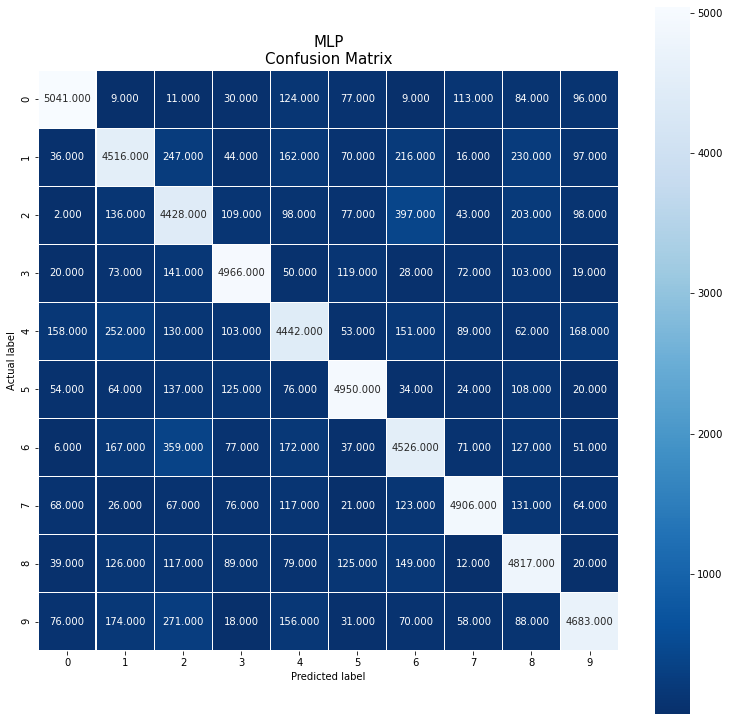

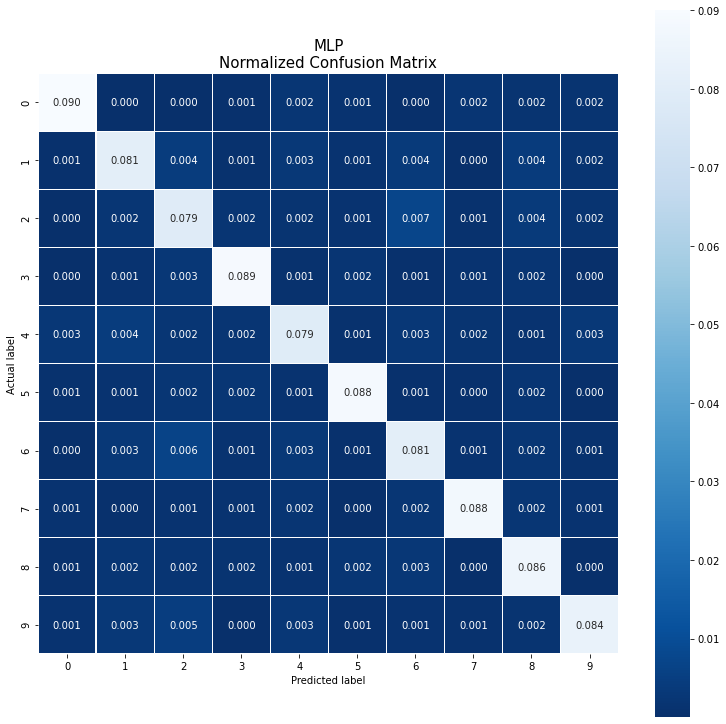

In [38]:
large_NN_prediction = mlp_large.predict(X_test)
cm = metrics.confusion_matrix(y_test, large_NN_prediction)

plt.figure(figsize = (13,13))
sns.heatmap(cm, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('MLP\nConfusion Matrix', size = 15);
plt.show()


cmn = metrics.confusion_matrix(y_test, large_NN_prediction, normalize='all')
plt.figure(figsize = (13,13))
sns.heatmap(cmn, annot = True, fmt='.3f', linewidths = .5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('MLP\nNormalized Confusion Matrix', size = 15);
plt.show()

## QUESTION 4
Compare the train and test error you got with a large number of samples with the best one you obtained with only 600 data points. Comment about the results you obtained.

- $m=600$ training data points: zero training error and $0.261$ test error 

- $m=4000$ training data points: zero training error and $ 0.154$ test error

I got a better accuracy on the larger training set sample: the multi-layer perceptron seems to generalize more and better classify in this case.

### TO DO 7

Plot an example that was missclassified by NN with m=600 training data points and it is now instead correctly classified by NN with m=4000 training data points.



Dataframe of the items that are  missclassified by NN with m=600 and correctly classified by NN with m=4000:
        Actual  large_NN_Prediction  NN_Prediction
0           5                    5            1.0
1           1                    1            5.0
4           3                    3            5.0
6           8                    8            2.0
7           4                    4            2.0
...       ...                  ...            ...
55994       3                    3            NaN
55995       9                    9            NaN
55997       9                    9            NaN
55998       6                    6            NaN
55999       3                    3            NaN

[47041 rows x 3 columns]



INPUT:


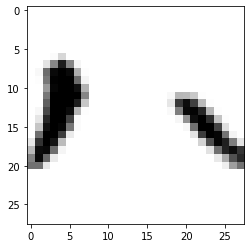

LABEL: 5
NN with m=600 prediction: 1.0
NN with m=4000 prediction: 5





In [31]:
# See above
# NN_prediction = #ADD YOUR CODE
# large_NN_prediction = #ADD YOUR CODE


df1 = pd.DataFrame({'Actual': y_test, 'large_NN_Prediction': large_NN_prediction})
df2 = pd.DataFrame({'NN_Prediction': NN_prediction})
df = pd.concat([df1, df2], axis = 1)

filtered_df = df[(df['NN_Prediction']!=df['Actual']) & (df['large_NN_Prediction']==df['Actual'])]
print("\n\nDataframe of the items that are  missclassified by NN with m=600 and correctly classified by NN with m=4000:\n", 
      filtered_df)

# Let's plot one of this dataframe's item 
indexes = filtered_df.index.tolist()

print("\n\n")
plot_input(X_test, y_test, indexes[0])
print("NN with m=600 prediction:", filtered_df.NN_Prediction.iloc[0])
print("NN with m=4000 prediction:", filtered_df.large_NN_Prediction.iloc[0])
print("\n\n")        

INPUT:


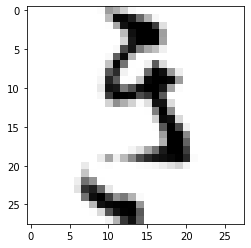

LABEL: 1
NN with m=600 prediction: 5.0
NN with m=4000 prediction: 1



INPUT:


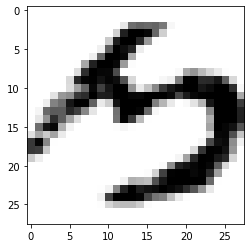

LABEL: 3
NN with m=600 prediction: 5.0
NN with m=4000 prediction: 3



INPUT:


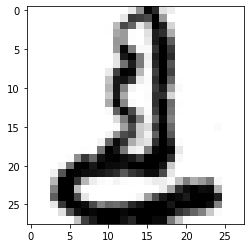

LABEL: 8
NN with m=600 prediction: 2.0
NN with m=4000 prediction: 8



INPUT:


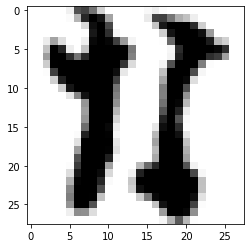

LABEL: 4
NN with m=600 prediction: 2.0
NN with m=4000 prediction: 4



INPUT:


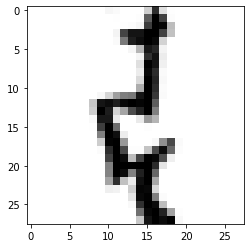

LABEL: 2
NN with m=600 prediction: 8.0
NN with m=4000 prediction: 2



INPUT:


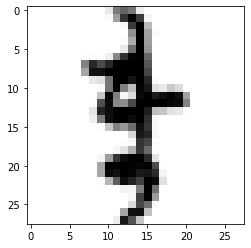

LABEL: 6
NN with m=600 prediction: 8.0
NN with m=4000 prediction: 6





In [32]:
# Let's plot a part (the beginning) of this dataframe's item 

for i in indexes[1:7]:
    plot_input(X_test, y_test, i)
    print("NN with m=600 prediction:", filtered_df.NN_Prediction.loc[i])
    print("NN with m=4000 prediction:", filtered_df.large_NN_Prediction.loc[i])
    print("\n\n")

### TO DO 8

Let's plot the weigths of the multi-layer perceptron classifier, for the best NN we get with 600 data points and with 4000 data points. The code is already provided, just fix variable names (e.g., replace mlp , mlp_large with your estimators) in order to have it working with your implementation



Weights with 600 data points:


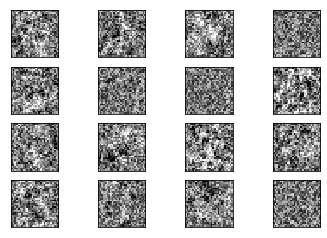



Weights with 4000 data points:


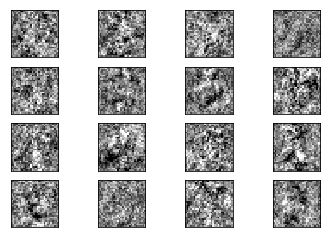

In [33]:
print("Weights with 600 data points:")

fig, axes = plt.subplots(4, 4)
vmin, vmax = mlp.coefs_[0].min(), mlp.coefs_[0].max()
for coef, ax in zip(mlp.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap = plt.cm.gray, vmin = .5 * vmin, vmax = .5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

print("\n\nWeights with 4000 data points:")

fig, axes = plt.subplots(4, 4)
vmin, vmax = mlp_large.coefs_[0].min(), mlp_large.coefs_[0].max()
for coef, ax in zip(mlp_large.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap = plt.cm.gray, vmin = .5 * vmin, vmax = .5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

## QUESTION 5

Describe what do you observe by looking at the weights.

The weights look unstructured in either cases, expect few cases with 600 data points which have a much smoother spatial appearance. Maybe some of the weights has not used at all or maybe the learning rate is too high.

### TO DO 9

Take the best SVM model and its parameters, you found in the last notebook. Fit it on a few data points and compute its training and test scores. Then fit also a logistic regression model with C=1. 

In [34]:
# use best parameters found in the SVM notebook, create SVM and perform fitting

m_training = 5000
X_train, X_test = X[:m_training], X[m_training:2*m_training]
y_train, y_test = y[:m_training], y[m_training:2*m_training]



best_SVM = {'C': 10, 'gamma': 0.01}
svm = SVC(kernel = "rbf", C = best_SVM["C"], gamma = best_SVM["gamma"])
svm.fit(X_train, y_train)


SVM_training_error =  1 - svm.score(X_train, y_train) 
SVM_test_error = 1 - svm.score(X_test, y_test)


print (bold + 'RESULTS FOR SVM' + end)

print(bold + "\n => Training score SVM:" + end, svm.score(X_train, y_train))
print(bold + "    Training error SVM:" + end, round(SVM_training_error, 4))

print(bold + "\n => Test score SVM:" + end, svm.score(X_test, y_test))
print(bold + "    Test error SVM:" + end, round(SVM_test_error, 3))


RESULTS FOR SVM

 => Training score SVM: 1.0
    Training error SVM: 0.0

 => Test score SVM: 0.9196
    Test error SVM: 0.08


In [35]:
# you can re-use your code from Lab 2

logisticRegr = linear_model.LogisticRegression(C = 1,  max_iter = 400)
fit = logisticRegr.fit(X_train, y_train)


LR_training_error = 1 - logisticRegr.score(X_train, y_train)
LR_test_error = 1 - logisticRegr.score(X_test, y_test)


print (bold + '\nRESULTS FOR LOGISTIC REGRESSION WITH REGULARIZATION (C=1)' + end)

print (bold + "\n => Regression - Training score:" + end, logisticRegr.score(X_train, y_train))
print (bold + "    Regression - Training error:" + end, round(LR_training_error, 4))

print (bold + "\n => Regression - Test score:" + end, logisticRegr.score(X_test, y_test))
print (bold + "    Regression - Test error:" + end, LR_test_error)


RESULTS FOR LOGISTIC REGRESSION WITH REGULARIZATION (C=1)

 => Regression - Training score: 0.9662
    Regression - Training error: 0.0338

 => Regression - Test score: 0.7668
    Regression - Test error: 0.23319999999999996


## QUESTION 6
Compare the results of Logistic Regression, SVM and NN. Which one achieve the best results? 

**SVM** - Test score: 0.9196$\newline$
**Logistic Regression** - Test score:  0.7668$\newline$
**Multi-layer perceptron** - Test score: 0.844 $\newline$
$\newline$ The SVM has archieved the best result.